In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

In [8]:
## USER INPUTS ##
today = datetime.today().strftime('%Y%m%d')
yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y%m%d')

dir = f'C:/Users/fitzpatrick/Desktop/Data/{today}/'

pcp_data = pd.read_csv(dir+f'CFS_APCP_forecasts_Sums_{yesterday}.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_{yesterday}.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_{yesterday}.csv',sep=',')

NN_model = tf.keras.models.load_model('NN_trained_model.keras')
GP_model = joblib.load('GP_trained_model.pkl')
RF_model = joblib.load('RF_trained_model.pkl')

In [9]:
X = pd.DataFrame({
    'su_pcp': pcp_data['sup_lake'],
    'er_pcp': pcp_data['eri_lake'],
    'on_pcp': pcp_data['ont_lake'],
    'mh_pcp': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_evap': evap_data['sup_lake'],
    'er_evap': evap_data['eri_lake'],
    'on_evap': evap_data['ont_lake'],
    'mh_evap': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_tmp': tmp_data['sup_lake'],
    'er_tmp': tmp_data['eri_lake'],
    'on_tmp': tmp_data['ont_lake'],
    'mh_tmp': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2
})

In [15]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled.shape)
# Predict on the test set
y_pred = GP_model.predict(X_scaled)

df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])
#df_y_pred = pd.DataFrame(y_pred, columns=['eri', 'ont', 'sup', 'mih'])

(40, 12)


In [16]:
df_y_pred['month'] = pcp_data['forecast_month']
print(df_y_pred)

         sup       eri       ont       mih  month
0   0.285679 -1.404503 -1.381698 -0.870047      8
1  -0.306721 -1.180175 -1.328084 -0.649324      9
2   0.553821 -1.494879 -1.282685 -0.606172     10
3   0.599490 -0.495785 -0.302744  0.684904     11
4  -0.828585  0.920380  0.877530 -0.009213     12
5  -0.275248  0.841056  0.691566  1.111610      1
6   0.056029  1.340143  1.548307  1.355855      2
7  -0.410943  0.601932  0.551001  0.068781      3
8   1.142948  0.559891  0.771992  0.946831      4
9   1.046735  0.296918 -0.182291  0.871944      5
10  0.010330 -1.252702 -1.241343 -0.524656      8
11  0.221619 -0.732993 -0.991072  0.034100      9
12  0.183497 -1.391266 -1.484643 -0.607343     10
13 -0.793444 -0.291099  0.532134 -0.513985     11
14 -1.118994  0.533945  0.546406 -0.273778     12
15 -0.916088 -0.015136  0.011293 -0.555880      1
16 -0.103998  1.936437  1.055381  0.742470      2
17 -0.519613  0.857711  0.823051  1.015539      3
18  0.302339  1.834103  2.019185  1.253354      4


In [20]:
def mean_min_max(df,lake):
    mean = df.groupby('month')[lake].mean()
    min = df.groupby('month')[lake].min()
    max = df.groupby('month')[lake].max()

    return mean, min, max

mean_su, min_su, max_su = mean_min_max(df_y_pred,'sup')
mean_er, min_er, max_er = mean_min_max(df_y_pred,'eri')
mean_on, min_on, max_on = mean_min_max(df_y_pred,'ont')
mean_mh, min_mh, max_mh = mean_min_max(df_y_pred,'mih')


In [21]:
df_mean = pd.DataFrame({
    'df_su': mean_su,
    'df_er': mean_er,
    'df_on': mean_on,
    'df_mh': mean_mh
})

df_min = pd.DataFrame({
    'df_su': min_su,
    'df_er': min_er,
    'df_on': min_on,
    'df_mh': min_mh
})

df_max = pd.DataFrame({
    'df_su': max_su,
    'df_er': max_er,
    'df_on': max_on,
    'df_mh': max_mh
})

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_9084\462877888.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],


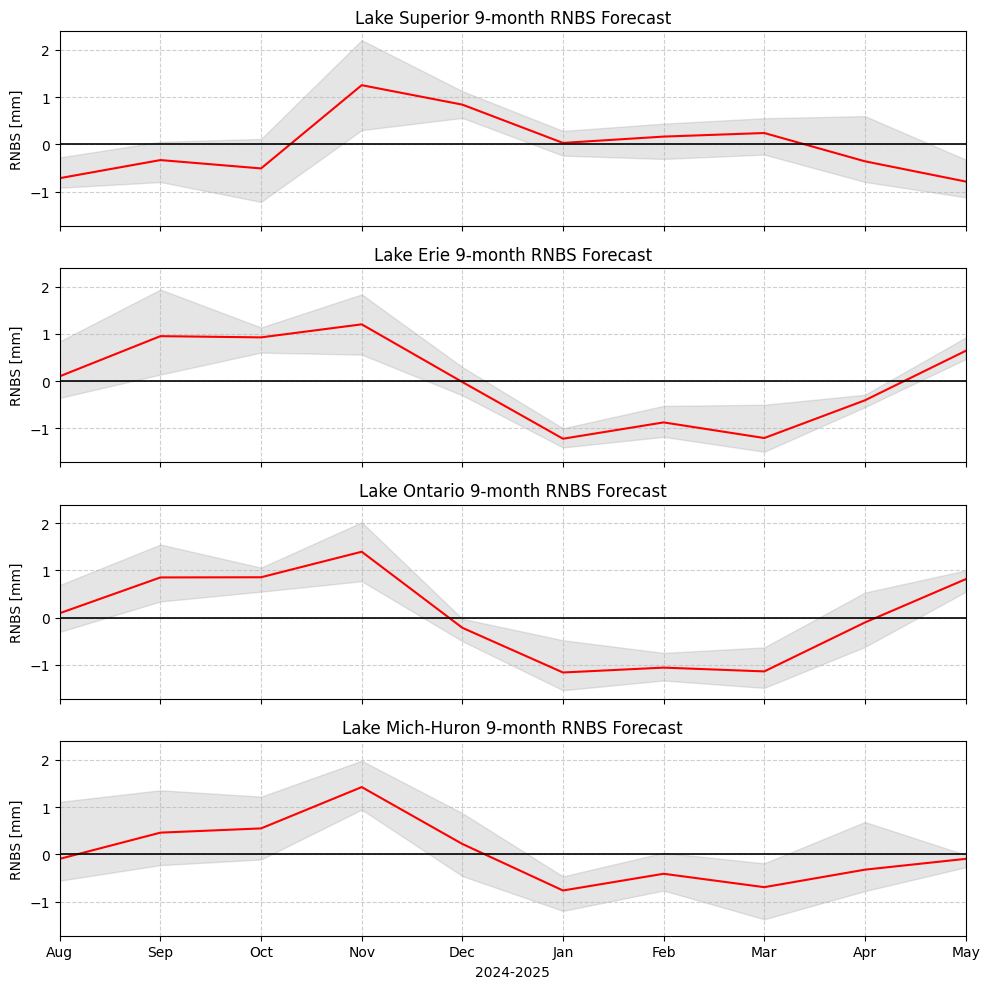

In [30]:
import calendar

def plot_rnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True, sharey=True)
    
    # Titles for the subplots
    titles = [
        'Lake Superior 9-month RNBS Forecast',
        'Lake Erie 9-month RNBS Forecast',
        'Lake Ontario 9-month RNBS Forecast',
        'Lake Mich-Huron 9-month RNBS Forecast'
    ]
    
    # Plot each dataset
    for i, (lake_name, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_ylabel('RNBS [mm]')
        axs[i].set_title(titles[i])
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 12
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i == 3:  # Set labels for the last subplot
            axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],
                                    calendar.month_abbr[df_y_pred['month'][2]], calendar.month_abbr[df_y_pred['month'][3]],
                                    calendar.month_abbr[df_y_pred['month'][4]], calendar.month_abbr[df_y_pred['month'][5]],
                                    calendar.month_abbr[df_y_pred['month'][6]], calendar.month_abbr[df_y_pred['month'][7]],
                                    calendar.month_abbr[df_y_pred['month'][8]], calendar.month_abbr[df_y_pred['month'][9]]])
    
    #plt.xlabel('2024-2025')
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage
x_values = np.arange(10)  # x-axis values from 0 to 9
data_dict = {
    'Lake Superior': (mean_su, min_su, max_su),
    'Lake Erie': (mean_er, min_er, max_er),
    'Lake Ontario': (mean_on, min_on, max_on),
    'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
}

plot_rnbs_forecast(x_values, data_dict)